### This notebook takes in csv dataset of input features and output variable to perform the following:
- Filtering of dataset based on season
- Training of neural network
- Obtaining average RMSE, MAE and standard deviation of AE of ANN predictions
- Plotting of RMSE against PV penetration rate

In [49]:
# Import libraries 
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from sklearn import preprocessing
import keras
from matplotlib.lines import Line2D
import time
from sklearn.model_selection import GridSearchCV

In [50]:
# Import training set
df1 = pd.read_csv (r"C:\Users\tangl\OneDrive\Engineering Course\Year 4\4YP\Training Datasets\Datasetv4_ML_all_1.csv",index_col=[0])
df2 = pd.read_csv (r"C:\Users\tangl\OneDrive\Engineering Course\Year 4\4YP\Training Datasets\Datasetv4_ML_all_2.csv",index_col=[0])

df = pd.concat([df1,df2])
# Remove Peak_all features
df = df.drop(df.columns[[14,15,16,17,18,19,20]],axis = 1)

In [53]:
X = df.iloc[:,:16]    
Y = df.iloc[:,-1:]
X = X.to_numpy()
Y = Y.to_numpy()

(X_train, X_test, y_train, y_test,) = train_test_split(X, Y,stratify = Y, test_size=0.1,random_state = 1)

## Select samples based on season
season = 2                                     # Change number based on desired season: Summer - 1, Winter - 2, Transition - 3
y_train = y_train[X_train[:, 14] == season]
y_test = y_test[X_test[:, 14] == season]
X_train = X_train[X_train[:, 14] == season, :]   
X_test = X_test[X_test[:, 14] == season, :]

## Remove season feature
X_train = np.delete(X_train,-2,axis=1)
X_test = np.delete(X_test,-2,axis=1)


sc_X = preprocessing.StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)

In [41]:
### Use the following code to extract half of the available data samples based in transitional seasons
#X_train = X_train[:5837,:]
#y_train = y_train[:5837]
#X_test = X_test[:640,:]
#y_test = y_test[:640]

In [42]:
def getresults(X_train,y_train,X_test,y_test):
    regr = MLPRegressor(hidden_layer_sizes = (270,270),max_iter=220, learning_rate_init=0.01, alpha = 0.0005).fit(X_train, y_train)
    results = regr.predict(X_test)
    total_rmse = mean_squared_error(y_test,results,squared=False)
    total_mae = mean_absolute_error(y_test,results)
    total_ae_std = np.std(abs(results - y_test))

    combined = np.vstack((y_test, results)).T
    y_values_by_x = {}
    for x, y in combined:
        y_values_by_x.setdefault(x, []).append(y)
    mse = {k: sum((k-v)**2)/len(v) for k, v in y_values_by_x.items()}
    rmse = {k: math.sqrt(v) for k, v in mse.items()}
    rmse_lists = sorted(rmse.items()) 
    x, rmse_y = zip(*rmse_lists) 

    return (total_rmse, total_mae, total_ae_std,rmse_y,x)

In [43]:
ave_rmse = 0
ave_mae = 0
ave_ae_std = 0
all_rmse_y =np.zeros(82)
repetitions = 5
for i in range(repetitions):
    (total_rmse, total_mae, total_ae_std,rmse_y,x) = getresults(X_train,y_train,X_test,y_test)
    ave_rmse = ave_rmse + total_rmse
    ave_mae = ave_mae + total_mae
    ave_ae_std = ave_ae_std + total_ae_std
    all_rmse_y = np.vstack([all_rmse_y,rmse_y])

ave_rmse = ave_rmse / repetitions
ave_mae = ave_mae / repetitions
ave_ae_std = ave_ae_std/repetitions
all_rmse_y = all_rmse_y[1:]

In [44]:
print(ave_rmse)
print(ave_mae)
print(ave_ae_std)

23.967663791172946
15.838965347431563
17.986584068126717


In [45]:
np.save('half_transition_rmse_y',all_rmse_y)


In [46]:
all_rmse_y = np.load("all_rmse_y.npy")
summer_rmse_y = np.load("summer_rmse_y.npy")
winter_rmse_y = np.load("winter_rmse_y.npy")
transition_rmse_y = np.load("half_transition_rmse_y.npy")

ave_all = np.mean(all_rmse_y,axis =0)
ave_summer = np.mean(summer_rmse_y,axis =0)
ave_winter = np.mean(winter_rmse_y,axis =0)
ave_transition = np.mean(transition_rmse_y,axis =0)

std_all = np.std(all_rmse_y,axis =0)
std_summer = np.std(summer_rmse_y,axis =0)
std_winter  = np.std(winter_rmse_y,axis =0)
std_transition = np.std(transition_rmse_y,axis =0)



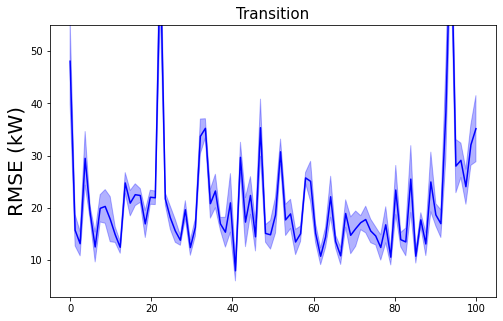

In [48]:
x_percentage = np.divide(x,372.6)
x_percentage = x_percentage*100
#x_percentage = x_percentage[:-1]
plt.figure(figsize=(8, 5))


plt.plot(x_percentage, ave_transition,color = 'blue')

#plt.fill_between(x_percentage, ave_summer + (std_summer)/2, ave_summer - (std_summer)/2, alpha = 0.3, color = 'blue')
#plt.fill_between(x_percentage, ave_winter + (std_winter)/2, ave_winter- (std_winter)/2, alpha = 0.3, color = 'blue')
plt.fill_between(x_percentage, ave_transition + (std_transition)/2, ave_transition - (std_transition)/2, alpha = 0.3, color = 'blue')
#plt.fill_between(x_percentage, ave_all + (std_all)/2, ave_all - (std_all)/2, alpha = 0.3, color = 'blue')

#plt.xlabel("Percentage of properties with installed PV (%)",fontsize = 13)
plt.ylabel("RMSE (kW)",fontsize=20)
plt.ylim((3,55))
#plt.legend()
plt.title('Transition',fontsize = 15)
plt.show()